# Project Group - 15
Members: 

         Guoheng Li 5939259

         Junpeng Li 5921856

         Haosen Luo 5936195
         
         Chenwei Peng 591838


# Contribution Statement

**Author 1**: Guoheng Li: background research, modelling

**Author 2**: Junpeng Li: data preprocessing

**Author 3**: Chenwei Peng: visualisation

**Author 4**: Haosen Luo: visualisation


# 1. Introduction



## 1.1 Background



The study of car-following models is crucial for transportation engineering and urban planning. These models provide crucial insights for congestion management, infrastructure planning, environmental impact assessment and safety improvement. However, different models are based on different assumptions, representations, and methodologies, which require real-world data to test their limitations and strengths, e.g., some models are unable to explain some specific car-following patterns. Our project is to extract real-world car following data and apply the model to analyze it, and to visualize the data based on this harm.

## 1.2 Research Objective



Therefore, in this project the objectives are:

 **Objective 1**: To what textent are the comprehensiveness and the goodness of the dataset we use? (Chapter 3.1)  

 **Objective 2**: Are there correlations or characteristics across different sets of car following variables(e.g.headway, follower's velocity and acceleration)? (Chapter 3.2)

 **Objective 3**: How to estimate the parameters for individual driver?  (Chapter 4.1)
 
 **Objective 4**: What are pros & cons using IDM?  (Chapter 4.2)

# 2. Framework



## 2.1 Data Used



This project uses the vehicle following dataset provided in [this paper](https://arxiv.org/pdf/2305.18921.pdf), containing over 29,000 segments of a human-driven vehicle following an autonomous vehicle (H-A) and 42,000 segments of a human-driven vehicle following a human-driven vehicle (H-H). The data consists of over 1,000 hours of sensory and motion data from fixed routes in urban and suburban environments in Palo Alto, CA, collected over a 4-month period.  
Translated with www.DeepL.com/Translator (free version)  
Seven regimes are considered in the dataset of regime of each vehicle pairs:  
  1. free acceleration (Fa)
  2. free deceleration not caused by the leading vehicle (Fd)
  3. cruising at a desired speed (C)
  4. acceleration following a leading vehicle (A)
  5. deceleration following a leading vehicle (D)
  6. constant speed following (F)
  7. standstill (S)  
   
The dataset also provides the time duration of each regime as well as the combination for each car-following case id which is for further analysis.


## 2.2 Data Preprocessing Pipeline

### 2.2.1 Organizing and exporting data
Define the function to extract the vehicle data from trainHA.zarr and trainHH.zarr, including the position, velocity, acceleration, and timestamps of the front vehicle x_lead, v_lead, a_lead, and the rear vehicle x_follow, v_follow, and a_follow, and import them into multi_data.csv after adding the id. In addition, extract the front and rear vehicle sizes size_lead, size_follow in each model, add id and save to multi_size.csv.  
### 2.2.2 Data Segmentation and Preprocessing
In the raw data processing of the vehicle following model, the vehicle dimensions and center point data are first extracted from multi_size and multi_data to calculate the distance between following vehicles.The rear distance (A_distance) and front distance (B_distance) are obtained using the formula and the results are output to the distance.csv file.  
### 2.2.3 Export of different following models
In the car_following model, the following states of the vehicle are different at different times, which are classified into 7 types.
all the following states and create separate csv files need to be extracted in order to explore the relationship between the different following states. 
| CASE_ID        | A                | D                | F                | Fa               | regime_combination | C  | Fd |
| -------------- | ---------------- | ---------------- | ---------------- | ---------------- | ------------------ | -- | -- |
| Scene ID for each set of car following data | duration for A regime | duration for D regime | duration for F regime | duration for Fa regime | combination of regimes |  duration for C regime  |  duration for Fd regime  |


![IMAGE](./images/regime.jpg)

Read the regimes string, identify the different heeling modes, and export the corresponding vehicle data from multi_data.csv to seven csv files named after each mode by length. Use Python regular expressions to filter the scenarios containing the three modes of the ADF, and export the data by the number of other scenarios to files such as ADF+1_multi_data.csv. Data visualization was performed afterwards.  
In the end, the data is organised as follows (due to the file size issue, we can't upload the file to Github repository):


In [24]:
# ├─HA
# |       A.csv
# |       ADF+1_multi_data.csv
# |       ... (the same directories as in HH directory)
# └─HH
#         A.csv
#         ADF+1_multi_data.csv
#         ADF+2_multi_data.csv
#         ADF+3_multi_data.csv
#         ADF+4_multi_data.csv
#         ADF_multi_data.csv
#         C.csv
#         D.csv
#         distance.csv
#         F.csv
#         Fa.csv
#         Fd.csv
#         multi_data.csv
#         multi_size.csv
#         regimes_list_HH_train.csv
#         S.csv

All the codes for the data preprocessing is held in .\files\src\data_proprocess

### 2.2.4 Data Exploration
In order to explore the relationship between the vehicle following dataset and common models, data exploration methods were used for analysis:  
- Calculate headway spacing and vehicle spacing.
- Analyze the effect of vehicle size on spacing.
- Perform statistical analysis: variance and mean.
- Analyze the relationship between vehicle attributes in different heeling models.
    
These analyses allow for further investigation of vehicle relationships in the follow-through model in subsequent sections and are presented in visual graphical form.


## 2.3 Modelling


The Intelligent Driver Model and Gipps Model will be used to verify their applications on different regimes, as a mean of analysing their behaviour patterns as well pros and cons. However, to do so there are some parameters left to be filled in. Therefore, calibrating the parameters first objectively and comprehensively is a must, i.e.  the parameters are calibrated by using algorithms to minimize the total car following trajectory loss, and applied to different regimes due to the huge discrepancy among various patterns.

![IMAGE](./images/image.png)



# 3. Data Exploration (Objective 1&2)

In [14]:
# import dependent libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import math


# DIRECTORIES
PROJECT_FILE = "./"
MULTI_SIZE_FILE = PROJECT_FILE + 'data/HH/multi_size.csv' 
MULTI_FILE = PROJECT_FILE + 'data/HH/multi_data.csv' 

# IPYNB CONFIG
%matplotlib inline


## 3.1 Objective 1: Data Description



### 3.1.1 Vehicle Size Distribution Description


It is important to analyze the size distribution of different types of vehicles in the study because vehicle size tends to reflect the characteristics of a particular vehicle model, e.g. longer vehicles may be trucks, which have lower acceleration rates.  
- Vehicle length frequency distribution plots show that most vehicles are between 2.5 and 7.5 meters long, with the highest frequencies in the 2.5 to 5 meter range.
- The histogram of vehicle length categories divides the vehicles into 6 categories according to their lengths, among which the number of "compact" vehicles is the highest.
- The pie chart shows that compact vehicles account for the largest percentage of vehicles, 47.9%, while mini vehicles account for the smallest percentage, 0.3%, indicating that the dataset consists mainly of compact and mini vehicles.

For simplicity, we use the range of vehicle length to represent the classification of vehicles, the corresponding table as follows [[4]](https://en.wikipedia.org/wiki/Car_classification):

| Class | Mini        | Small   | Compact   | Mid-sized   | Medium   | Large | 
| -------------- | -------------- | ---------------- | ---------------- | ---------------- | ---------------- | ------------------ | 
| Length(m) | 3.5< | 3.5-4 | 4-4.6 | 4.6-4.8 | 4.8-5.0 | >5 |  



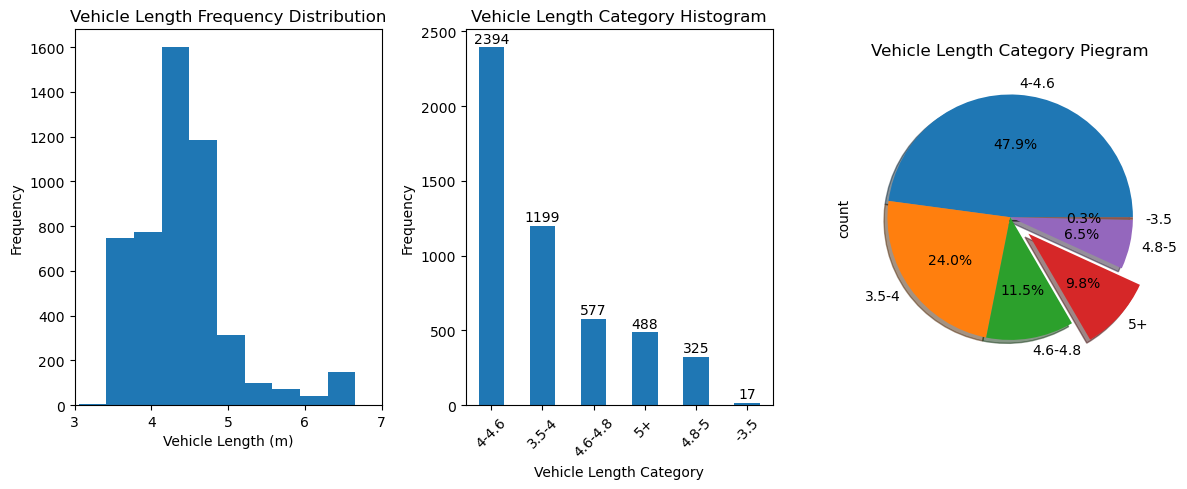

In [15]:
df_multi_size = pd.read_csv(MULTI_SIZE_FILE)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# First subplot - Histogram
axes[0].hist(df_multi_size['size_lead'], bins=50)
axes[0].set_xlabel('Vehicle Length (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Vehicle Length Frequency Distribution')
axes[0].set_xlim([3, 7])

# Second subplot - Length Category Histogram
bins = [0, 3.5, 4, 4.6, 4.8, 5, max(df_multi_size['size_lead'].values)]
#['Mini(-3.5)', 'Small(3.5-4)', 'Compact(4-4.6)', 'Mid-sized(4.6-4.8)', 'Medium(4.8-5)', 'Large(5+)']
labels = ['-3.5', '3.5-4', '4-4.6', '4.6-4.8', '4.8-5', '5+']
df_multi_size['length_category'] = pd.cut(df_multi_size['size_lead'], bins=bins, labels=labels, right=False)
value_counts = df_multi_size['length_category'].value_counts()

axes[1] = value_counts.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Vehicle Length Category')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Vehicle Length Category Histogram')
axes[1].tick_params(axis='x', rotation=45)

explode = [0 ,0, 0, 0.2, 0, 0]
axes[2] = value_counts.plot(kind='pie', explode=explode, ax=axes[2], autopct="%1.1f%%", shadow=True, startangle=0)
axes[2].set_title('Vehicle Length Category Piegram')

# Add specific frequency values on the second subplot
for i, v in enumerate(value_counts):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the entire figure
plt.show()

**Although the dataset contains more compact and mini-vehicles than large vehicles, this may affect the choice of parameters in the model, e.g. large vehicles are expected to have lower acceleration. However, this bias can be eliminated by using different sets of parameters to characterize the heterogeneity of the vehicles.**


### 3.1.2 Variables in Data

According to the classification above, and considering the complexity of the categorization, the vehicles are divided into 3 types based on their length. The classification criterior is as follows:

In [21]:
def get_car_type(length):
    
    if 5 < length:
        return "Large"
    if length <= 4.6:
        return "Small"
    if 4.6 < length <= 5:
        return "Medium"
    
    return None

In order to lay an accurate account for the car following data, the velocity $v_\text{lead}$, $v_\text{follow}$, the acceleration $a_\text{lead}$, $a_\text{follow}$, and the distance $s$ between two vehicles are indispensible. Therefore, the distribution and the basic statistics of these data are to be acquired.   
The velocity maxima for both vehicle types are low, suggesting urban street data rather than freeway, affecting driver behavior and car-following parameter estimation. The average acceleration is near zero with notable outliers potentially indicating data errors. High variance and boxplot tails indicate scattered variable distributions, suggesting underlying car-following behavior patterns despite vehicle type differences. Distance, critical for car-following models, shows many outliers in the boxplot, hinting at potential free-flow conditions. The skewed distribution, with a center around 20 meters, suggests that larger distances occur less frequently.

,v_follow,v_lead,a_follow,a_lead,distance
count,1006176.00,1006176.00,1006176.00,1006176.00,1006176.00
mean,9.16,9.37,0.15,0.21,24.00
std,6.52,6.66,0.75,0.73,14.68
min,-2.70,-2.57,-8.55,-7.96,0.26
25%,1.89,1.70,-0.17,-0.10,12.27
50%,10.57,11.06,0.03,0.05,20.84
75%,15.09,15.32,0.45,0.48,31.61
max,22.92,24.10,11.24,9.91,84.85


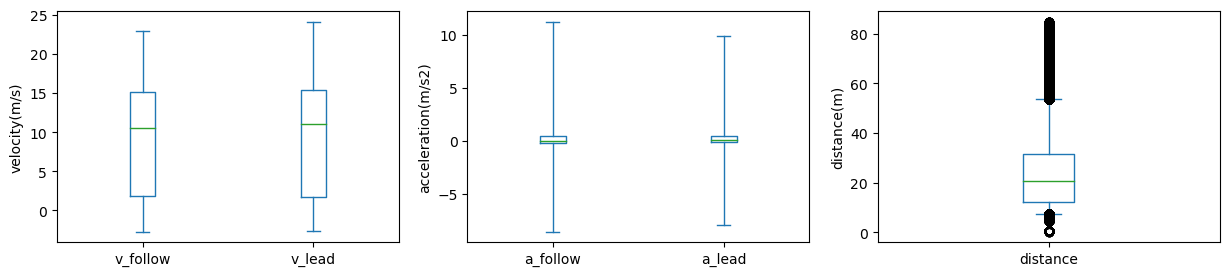

In [28]:
# Define the directory
FOLDER_PATH = PROJECT_FILE + "data/HH"
vars = ["v_lead" , "a_lead", "v_follow", "a_follow"]
vars_label = ["velocity_lead(m/s)", "acceleration_lead(m/s^2)", "velocity_follow(m/s)", "acceleration_follow(m/s^2)"]
rows = 2

# needed data
df_size = pd.read_csv(MULTI_SIZE_FILE)
df = pd.read_csv(MULTI_FILE)
pd.set_option("display.float_format", lambda X: "%.2f" % X)
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

df["distance"] = df["x_lead"] - df["x_follow"]
df[["v_follow", "v_lead"]].plot(kind="box", whis=[0, 100], ax=axs[0], ylabel="velocity(m/s)")
df[["a_follow", "a_lead"]].plot(kind="box", whis=[0, 100], ax=axs[1], ylabel="acceleration(m/s2)")
df["distance"].plot(kind="box", whis=[5, 95], ax=axs[2], ylabel="distance(m)")
df[["v_follow", "v_lead", "a_follow", "a_lead", "distance"]].describe()

**The varied speeds and accelerations reflect the diverse driving behaviors and car-following patterns on this road, indicating a broad spectrum of driver habits and requiring further investigation.**

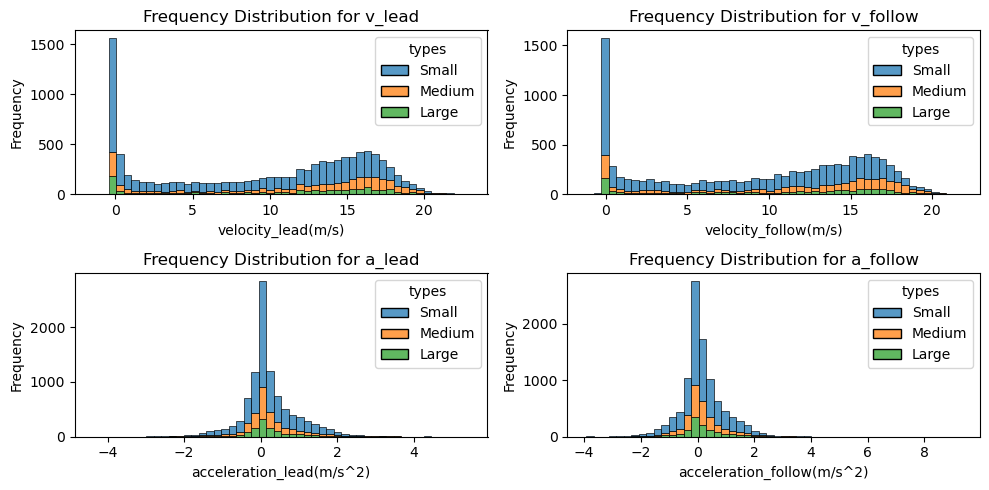

In [29]:
# Create a new plot, with subplots of 2 x 3
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# extract follow acceleration data
follow_acceleration = df.groupby('ID').sample(2, replace=True)
follow_acceleration = follow_acceleration.merge(df_size, on='ID')
follow_acceleration["types"] = follow_acceleration["size_follow"].apply(get_car_type)

# Iterate each csv file
for i, var in enumerate(vars):
    # compute row and column index
    row = i % rows
    col = i // rows
    
    # Draw the histograms
    sns.histplot(data=follow_acceleration, x=var, bins=50, ax=axs[row, col], hue="types", multiple="stack")
    axs[row, col].set_xlabel(vars_label[i])
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Frequency Distribution for {var}')

# Remove redundant white subplots
for d in range(i + 1, math.ceil(rows*((len(vars) / rows)))):

    # compute row and column index
    row = d % rows
    col = d // rows

    fig.delaxes(axs[row, col])
plt.tight_layout()
plt.show()

### 3.1.3 Rationality for Deviding Vehicles into Different Vehicle Types


The images depict various car-following states: Acceleration, Cruise, Decelerate, Following, Free acceleration, Free Deceleration, and Still.  
- In acceleration and deceleration (first and third images), the speed difference between following and lead cars is typically small during acceleration, often zero, suggesting parallel speeds. During deceleration, this difference widens, with following cars usually moving faster. The free acceleration and deceleration states mirror these trends.
- In cruising, the speed difference clusters near zero due to similar vehicle speeds. In the following state, this difference spreads out more due to lead car speed fluctuations influencing the follower.
- In stillness, the speed difference is predominantly zero.  
**These regimes are segmented to enhance the estimation of car-following parameters across different driving behaviors.**

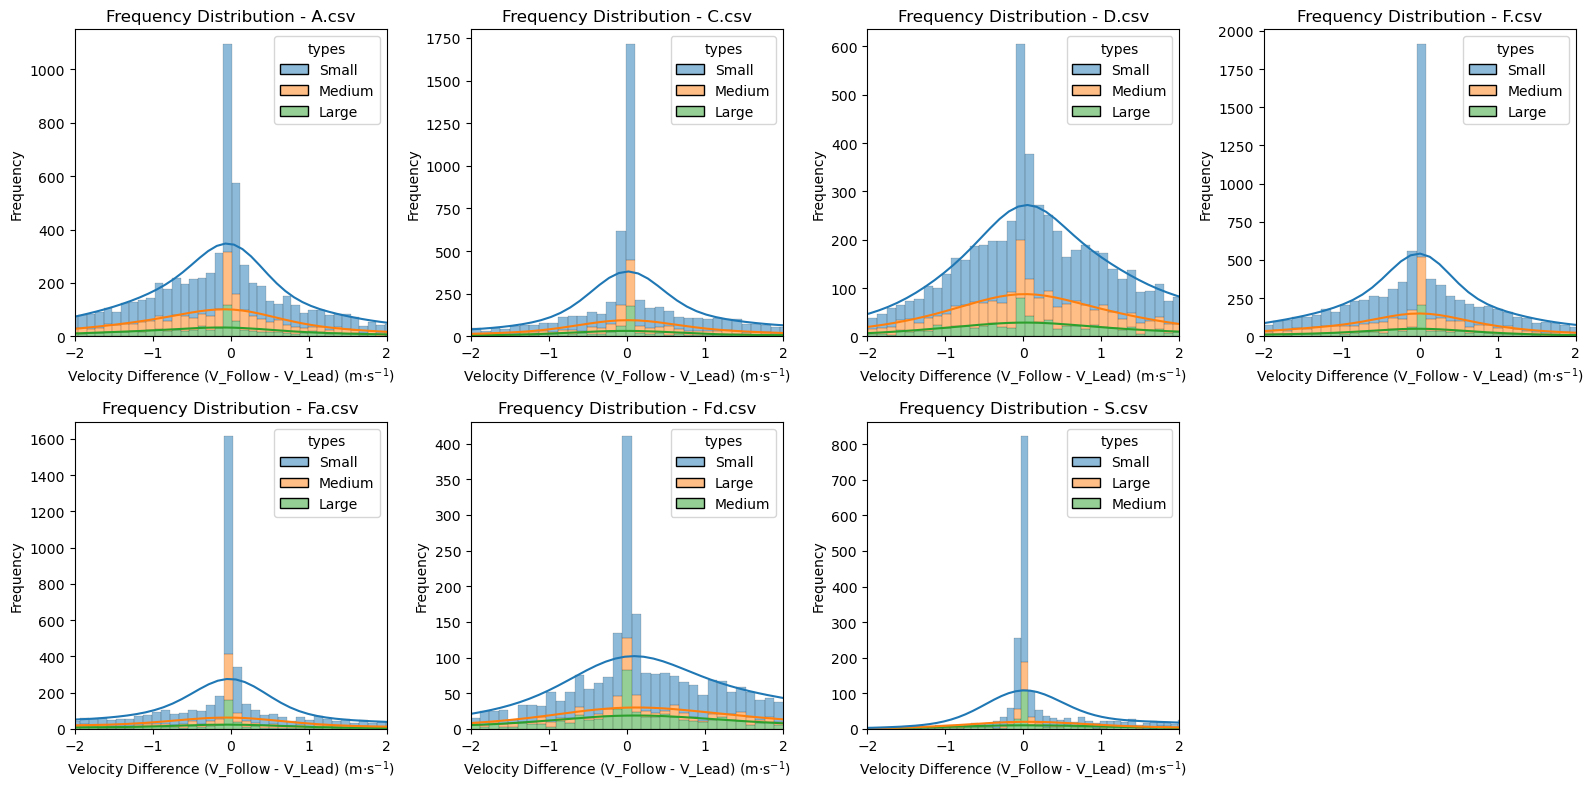

In [30]:
# Define the directory
FOLDER_PATH = PROJECT_FILE + "data/HH"
# csv_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv') and f.startswith("ADF")]
csv_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv') and not f.startswith("ADF") and f[0].isupper()]

def plot_dist(csv_files, var_name, label, rows=2, xlim=None, bins=200):
    cols = math.ceil(len(csv_files) / rows)
    fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
    df_size = pd.read_csv(MULTI_SIZE_FILE)

    # Iterate each csv file
    for i, csv_file in enumerate(csv_files):
        # construct a complete directory
        file_path = os.path.join(FOLDER_PATH, csv_file)
        df = pd.read_csv(file_path)
        df['diff_velo'] = df['v_follow'] - df['v_lead']
        
        # extract follow acceleration data
        follow_acceleration = df.groupby('ID').sample(2, replace=True)
        follow_acceleration = follow_acceleration.merge(df_size, on='ID')
        follow_acceleration["types"] = follow_acceleration["size_follow"].apply(get_car_type)
        
        # compute row and column index
        row = i // cols
        col = i % cols
        
        # Draw the histograms
        sns.histplot(data=follow_acceleration, bins=bins, x=var_name, ax=axs[row, col], hue="types", kde=True, multiple="stack")
        axs[row, col].set_xlabel(label)
        axs[row, col].set_xlim(xlim)
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_title(f'Frequency Distribution - {csv_file}')

    # delete the redundant subplots automatically
    for d in range(i + 1, cols*rows):
        
        # compute row and column index
        row = d // cols
        col = d % cols
        fig.delaxes(axs[row, col])

    plt.tight_layout()
    plt.show()
plot_dist(csv_files, var_name="diff_velo", label='Velocity Difference (V_Follow - V_Lead) (m$\cdot$s$^{-1}$)', rows=2, xlim=[-2, 2], bins=200)


### 3.1.4 Speed & Acceleration Distribution Histograms for Following Vehicles in Different Modes



Different ADF modes exhibit distinct speed distributions, reflecting varying macroscopic traffic flow characteristics.For example, in the ADF mode, the traffic model may depict that most vehicles on the road maintain relatively stable speeds for the majority of the time. In the ADF mode, the model portrays relatively stable driving behavior. In ADF+1 and ADF+2 modes, vehicles demonstrate smoother acceleration patterns, which are particularly useful for simulating typical traffic conditions, such as congestion analysis during peak hours. This provides valuable guidance for parameter selection in later modeling, enhancing the ability to simulate and understand vehicle behavior and traffic flow in different traffic scenarios.

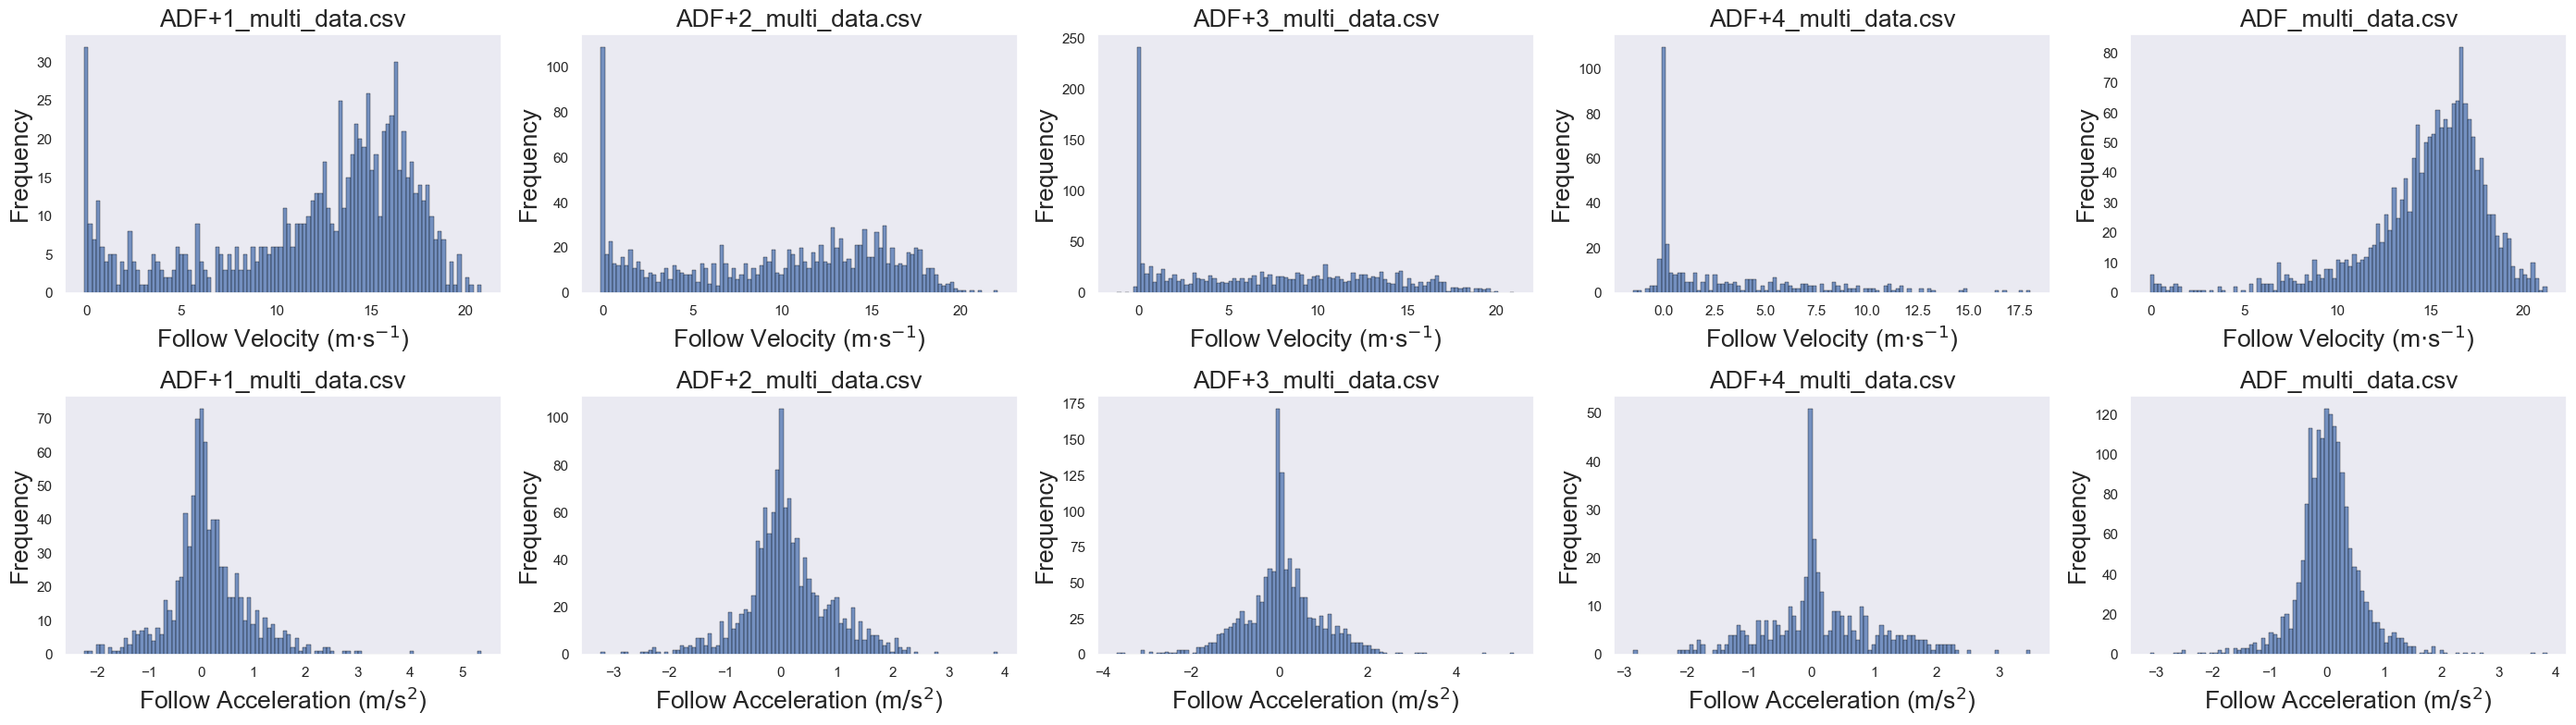

In [43]:
# new directory
DIR = PROJECT_FILE + "data/HH"
csv_files = [f for f in os.listdir(DIR) if f.endswith('.csv') and f.startswith("ADF")]
fig, axs = plt.subplots(2, 5, figsize=(28, 8))

for i, csv_file in enumerate(csv_files):

    # construct a complete directory
    file_path = os.path.join(DIR, csv_file)
    df = pd.read_csv(file_path)
    
    # extract data we need and sample to make the number of data entry from each scene is consistent
    data = df.groupby('ID').sample(2)
    
    # calculate index
    row = 0 
    col = i

    # plotting
    sns.histplot(data['v_follow'], bins=100, kde=False, edgecolor='black', ax=axs[row, col])
    axs[row, col].set_xlabel('Follow Velocity (m$\cdot$s$^{-1}$)', fontsize=19)
    axs[row, col].set_ylabel('Frequency', fontsize=19)
    axs[row, col].set_title(f'{csv_file}', fontsize=19)
    
    sns.histplot(data['a_follow'], bins=100, kde=False, edgecolor='black', ax=axs[row + 1, col])
    axs[row + 1, col].set_xlabel('Follow Acceleration (m$/$s$^{2}$)', fontsize=19)
    axs[row + 1, col].set_ylabel('Frequency', fontsize=19)
    axs[row + 1, col].set_title(f'{csv_file}', fontsize=19)

plt.tight_layout()
plt.show()

## 3.2 Objective 2: Correlation Analysis


### 3.2.1 Relationship between Following Vehicle Speed and Headway


The charts demonstrate the correlation between vehicle headway and average following speed for different vehicle sizes. Medium-sized vehicles most frequently follow at around 16 m/s with a 20-meter headway, while small-sized vehicles show less variation, indicating steadier driving behavior. Large vehicles tend to follow closer, with speeds around 17 m/s and headways under 15 meters.  
**The data generally shows that vehicles increase speed with longer following distances, likely due to drivers' perception of safety with more space ahead, informing car-following model development for more accurate driver behavior prediction across various traffic scenarios.**

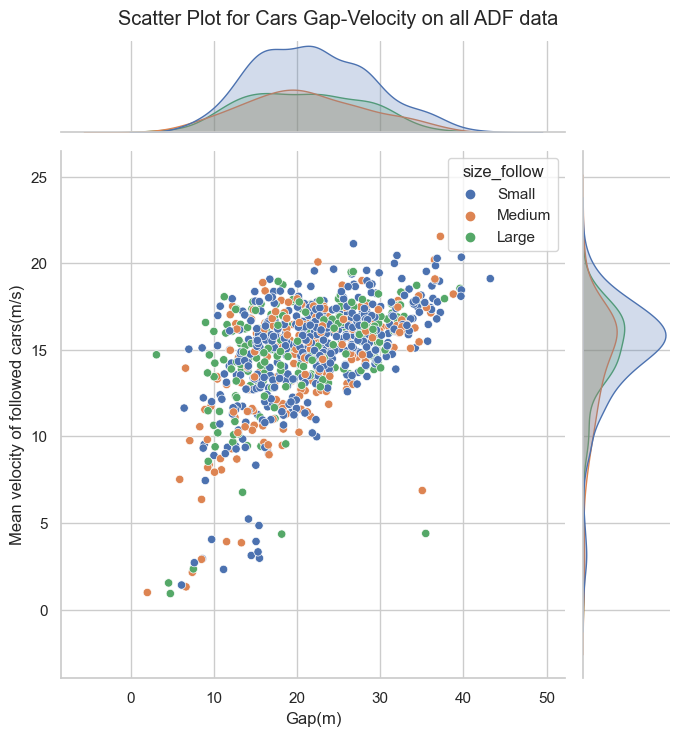

In [32]:
#　define the path
FOLDER_PATH = PROJECT_FILE + "data/HH"
HH_file_path = PROJECT_FILE + 'data/HH/multi_size.csv' 

df2 = pd.read_csv(HH_file_path)  # read the HH file in advance
df1 = pd.read_csv(FOLDER_PATH + '/ADF_multi_data.csv')

df1['x_lead_follow_diff'] = df1['x_lead'] - df1['x_follow']
mean_x_lead_follow_diff = df1.groupby('ID')['x_lead_follow_diff'].mean()

# merge DF1 and DF2, match with the ID key
df_combined = df1.merge(df2, on='ID')
types = df_combined["size_follow"].apply(get_car_type)

# calculate half_size_sum，using size_lead和size_follow
half_size_sum = (df_combined['size_lead'] + df_combined['size_follow']) * 0.5
s = mean_x_lead_follow_diff - half_size_sum
car_0_to_1000 = df_combined
mean_a_follow = df_combined.groupby('ID')['v_follow'].mean()

sns.set(style="whitegrid")
g = sns.jointplot(x=s, y=mean_a_follow, data=car_0_to_1000, kind="scatter", hue=types, height=7)
g.fig.suptitle(f'Scatter Plot for Cars Gap-Velocity on all ADF data', y=1.02)
g.set_axis_labels("Gap(m)", "Mean velocity of followed cars(m/s)")
plt.show()


### 3.2.2 Scatter Plots of Speed and Corresponding Acceleration for Different Vehicles


- Scatter Heatmap for Lead Cars' Velocity-Acceleration:
  The heatmap shows most lead cars exhibit steady speeds with minimal acceleration at low velocities, while higher velocities present a wider spread in acceleration, indicating variable driving behaviors.
- Scatter Heatmap for Follow Cars' Velocity-Acceleration:
  The heatmap for follow cars displays a similar pattern of stability at lower speeds, but at higher velocities, acceleration distribution is more concentrated, suggesting more conservative driving behavior compared to lead cars.  
**At low speeds, vehicles demonstrate consistent speed and acceleration, while at higher speeds, lead cars show varied speed changes, and following cars are more conservative, which could influence the development of car following models by highlighting different behavior patterns.**

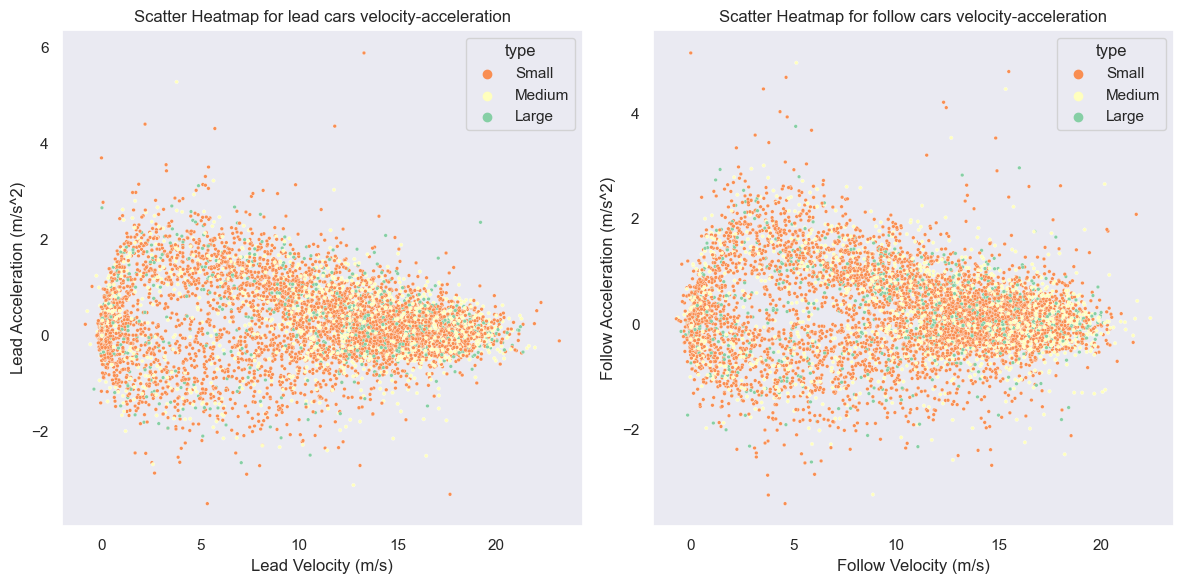

In [22]:
# Read data for both plots
sns.set_theme(style="dark")
file_path = MULTI_FILE
df = pd.read_csv(file_path)
df_size = pd.read_csv(MULTI_SIZE_FILE)
df = df.merge(df_size, on='ID')
df["type"] = df["size_follow"].apply(get_car_type)
df_grouped = df.groupby("ID").sample(2, replace=2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot - Lead Cars
axes[0].set_title('Scatter Heatmap for lead cars velocity-acceleration')
axes[0].set_xlabel('Lead Velocity (m/s)')
axes[0].set_ylabel('Lead Acceleration (m/s^2)')
sns.scatterplot(x=df_grouped['v_lead'], y=df_grouped['a_lead'], s=7, color=".15", ax=axes[0], hue=df_grouped["type"], palette="Spectral")
# sns.kdeplot(x=x_lead, y=y_lead, levels=5, color="w", linewidths=1, ax=axes[0])

# Second subplot - Follow Cars
axes[1].set_title('Scatter Heatmap for follow cars velocity-acceleration')
axes[1].set_xlabel('Follow Velocity (m/s)')
axes[1].set_ylabel('Follow Acceleration (m/s^2)')
sns.scatterplot(x=df_grouped["v_follow"], y=df_grouped["a_follow"], s=7, color=".15", ax=axes[1], hue=df_grouped["type"], palette="Spectral")

# Adjust the spacing between subplots
plt.tight_layout()
# Show the entire figure
plt.show()

## 3.3 Conclusion

Back to the question we put forward at first:   
How to evaluate the comprehensiveness and the goodness of the dataset we use? Are there correlations or characteristics across different sets of car following variables(e.g.headway, follower's velocity and acceleration)?  
- There exists heterogeneity in different driving behaviours, in order to describe these heterogeneity, different parameters sets are applied into models to describe the driving behaviour characteristics of different drivers(for example, how aggressive a driver is.). High diversity in drviers performance means ensures the comprehensiveness of the data we use.
- Different extended ADF regimes data exhibit distinct speed distributions, reflecting different macroscopic traffic flow characteristics, which ensures that the diversity of data for parameter estimation in car following models. Moreover, the using ADF regimes data to estimate driving behaviours has been widely accepted. Therefore, the data we decide to use is comprehensive and diverse enough to describe different driving behaviours.
- There are correlations between velocity and acceleration & gap between vehicles, for example, when driving at higher speed, driviers are tend to be less aggressive(i.e. less change in acceleration), and larger the gap between 2 vehicles is, the higher velocity the follower is in order to fill the gap till reaching the rear of the leading vehicle. These 2 observations provide 2 fundamental assumptions to formulate the models below.

# 4. Models, Parameters Estimation & Pros and Cons (Objective 3&4)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import random

TEST_NUM = 500
PROJECT_FILE = "..\data\HA"
DEBUG = False

## 4.1 Objective 3: Models

### 4.1.1 Desired Measures Models (Intelligent Driver Model)


The model presumes that each driver has a desired velocity, headway, and the drivers try to minimize the gap between the actual value and the desired value, while constrained by a variety of conditions, for instance safety distances. Intelligent Driver Model(IDM) is catagorized in this catagorization:  
Drivers try to minimize the following distance, and minimize both the speed difference and desired headway as well. In IDM model:  
1. The influence factors include own speed $v$, the bumper-to-bumper gap $s$ to the lead vehicle, and the difference of the speed $\Delta v = v - v_{\text{lead}}$  
2. The model only outputs the acceleration $a$ on the following car.  
3. The model parameters are driving styles.  
The IDM model equations are fomulated as follows:  
$$
\begin{aligned}
&\frac{dv}{dt} = a\left[1 - \left(\frac{v}{v_0}\right)^\sigma - \left(\frac{s^*(v, \Delta v)}{s}\right)^2 \right]\quad (1)\\  
&s^*(v, \Delta v) = s_0 + \max\left[0, \left(vT+\frac{v\Delta v}{2 \sqrt{ab}}\right)\right] \quad (2)
\end{aligned}
$$

where,  
- $\frac{dv}{dt}$ is the acceleration the follower vehicle will achieve in the next timestep.
- $a$ is the desired acceleration.
- $b$ is the desired deceleration.
- $v$ is the velocity of the follower in the current timestep.
- $v_0$ is the desired velocity of the follower.
- $s$ is the front-to-rear gap between 2 vehicles, which can be calculated by $x_\text{lead}(t)-x_\text{follow}(t) - \frac{1}{2}(l_\text{lead} + l_\text{follow})$
- $s^*(v,\Delta v)$ is the desired dynamical gap.


In [51]:
# wrap the car trajectory, velocity, acceleration data into a class Car, and also car size
class Car:
    def __init__(self, size: float, xs: np.array = [], vs: np.array = [], a_s: np.array = []) -> None:
        self.vs = vs  # a list consist of all velocities in all timesteps.
        self.xs = xs
        self.a_s = a_s
        self.size = size

In [ ]:
# given parameters dictionary, update and calculate the IDM model
class IDM:
    
    def __init__(self, param: dict) -> None:
        self.v0 = param['v0']  # the velocity the vehicle would drive at in free traffic
        self.s0 = param['s0'] # a minimum desired net distance.
        self.T = param['T'] # the minimum possible time to the vehicle in front
        self.a = param['a'] # the maximum vehicle acceleration
        self.b = param['b'] # a positive number (comfortable breaking deceleration)
        self.sigma = 4 # exponent factor, usually set to 4

    def get_desired_s(self, v_this, delta_v_i):
        # calculate the s* in the equation 2
        desired_s = v_this * self.T + v_this * delta_v_i / (2 * np.sqrt(self.a * self.b))
        return self.s0 + max(0, desired_s)
    
    def get_new_a(self, v_this, v_front, s_this):
        # calculate the next acceleration using equation 1
        delta_v_i = v_this - v_front
        
        a_next = self.a * (1 - np.power(v_this / self.v0, self.sigma) - np.power((self.get_desired_s(v_this, delta_v_i) / s_this), 2))
        return a_next
    
    def update(self, lead_car: Car, this_car: Car, time_steps):
        """
        update the next displacement, velocity based on the acceleration we derive.   
        """
        assert this_car is not None
        
        N = len(lead_car.xs)
        
        for i in range(1, N):

            time_step = time_steps[i] - time_steps[i - 1]
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]
            
            gap_now = lead_s_now - this_s_now - 1/2 * (lead_car.size + this_car.size)  # the distance is head's distance
            this_v_a = self.get_new_a(this_v_now, lead_v_now, gap_now)
            # update with the equation 3
            if this_v_now + this_v_a * time_step < 0:
                this_car.vs.append(0)
            else:
                this_car.vs.append(this_car.vs[i - 1] + time_step * this_v_a)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step + 1 / 2 * this_v_a * pow(time_step, 2))
            this_car.a_s.append(this_v_a)

### 4.1.2 Result


Even though the two models above are formualted in the form of continuous time domain, in order to simulate the car-following models on computer, we have to assume that the domain is discrete:
$$
\begin{aligned}
v(t+\Delta t) &= v(t) + \frac{dv}{dt} \Delta t\\
x(t+\Delta t) &= x(t) + v(t)\Delta t + \frac{1}{2} \frac{dv}{dt} (\Delta t)^2 \quad (3)
\end{aligned}
$$

According to the dataset, the timestep is set to be $0.1$ (s) for each entry of data. Thus, we decide to conform to that convention.

In [18]:
## preprocessing data 

# load data
CARS = np.loadtxt(os.path.join(PROJECT_FILE, "ADF_multi_data.csv"), delimiter=",", skiprows=1)
SIZES = np.loadtxt(os.path.join(PROJECT_FILE, "multi_size.csv"), delimiter=",", skiprows=1)

test_scenes = []
sizes = []

available_ids = np.unique(CARS[:, 0])[:TEST_NUM]

# filter data based on the scene id
for i in available_ids:
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))
    sizes.append(np.squeeze(SIZES[np.where(SIZES[:, 0] == i), 1:], (0, 1)))

TOTAL TIME STEP: 230


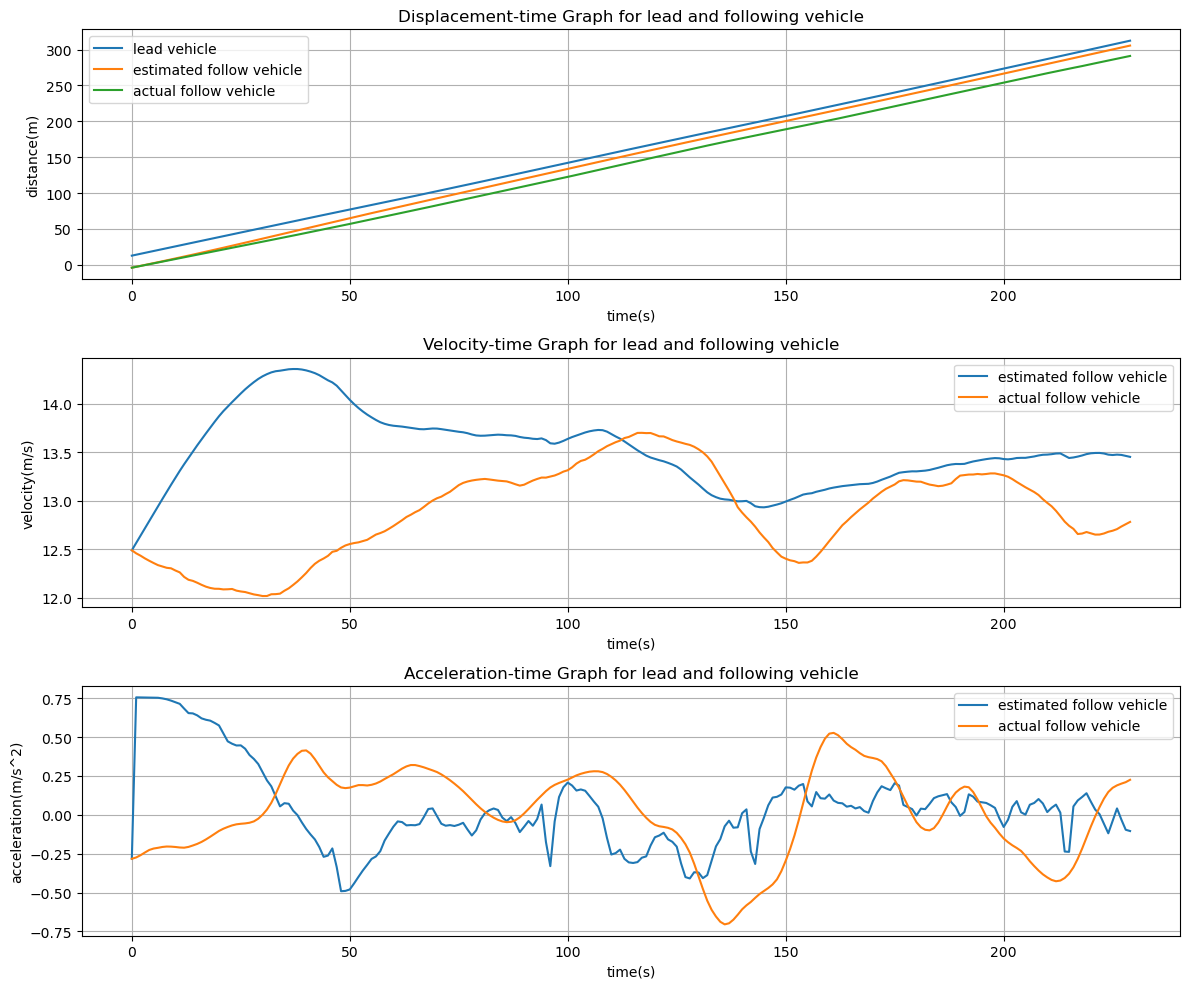

In [47]:
# random parameter set
param = {
    "v0": 30,
    "s0":  2,
    "T": 0.02,
    "a": 0.8,
    "b": 3,
    "sigma": 4
}

# test scene id for example
i = 100

def get_car_following_images(i, param):

    # get desired test scene based on the id
    test_scene = test_scenes[i]
    size = sizes[i]
    timesteps = test_scene[:, 7]

    print("TOTAL TIME STEP: %d" %test_scene.shape[0] )

    # get car following data from the test scene
    car_front = Car(size[0], test_scene[:, 1], test_scene[:, 2], test_scene[:, 3])
    car_follow = Car(size[1], [test_scene[0, 4]], [test_scene[0, 5]], [test_scene[0, 6]])
    car_follow_real = Car(size[1], [test_scene[:, 4]], [test_scene[:, 5]], [test_scene[:, 6]])

    # evaluate the trajectory of the following car based on the given parameter set
    idm = IDM(param)
    idm.update(car_front, car_follow, timesteps)

    # plotting
    fig, axes = plt.subplots(3, 1, figsize=(12,10))

    axes[0].plot(car_front.xs, label="lead vehicle")
    axes[0].plot(car_follow.xs, label="estimated follow vehicle")
    axes[0].plot(car_follow_real.xs[0], label="actual follow vehicle")
    axes[0].legend()
    axes[0].set_title("Displacement-time Graph for lead and following vehicle")
    axes[0].set_xlabel("time(s)")
    axes[0].set_ylabel("distance(m)")
    axes[0].grid()

    axes[1].plot(car_follow.vs, label="estimated follow vehicle")
    axes[1].plot(car_follow_real.vs[0], label="actual follow vehicle")
    axes[1].legend()
    axes[1].set_title("Velocity-time Graph for lead and following vehicle")
    axes[1].set_xlabel("time(s)")
    axes[1].set_ylabel("velocity(m/s)")
    axes[1].grid()

    axes[2].plot(car_follow.a_s, label="estimated follow vehicle")
    axes[2].plot(car_follow_real.a_s[0], label="actual follow vehicle")
    axes[2].legend()
    axes[2].set_title("Acceleration-time Graph for lead and following vehicle")
    axes[2].set_xlabel("time(s)")
    axes[2].set_ylabel("acceleration(m/s^2)")
    axes[2].grid()

    plt.tight_layout()
    plt.show()

get_car_following_images(i, param)

## 4.2 Objective 4: Parameter Estimation

### 4.2.1 Genetic Algorithm for IDM parameter estimation

After deriving the models,calibrating their parameters with real world data is essential to improve their performance. However,it's not a easy thing to calibrate the parameters with the real-life data.   
First, Based on the research of Anshuman[2], in order to calibrate the IDM model, the data are required to meet the completeness condition, i.e. one scenario consists of at least A(Acceleration), D(Deceleration) and F(Following) regimes.  
Therefore, in the data preprocessing stage, the data has been already split into ADF, ADF+1, ADF+2 and ADF+n for further process.  
Secondly, the popular calibration methods is Genetic Algorithms(GA), which is a method for solving optimization problems that is based on natural selection, the process that drives biological evolution. After achieving the optimal value for minimizing the loss function (which we will define later) on the train dataset, it's safe to identify that they are the approximate optimal set of parameters, due to the GA is an evolutionary algorithms, which determines that the solution it provides is local optimal, instead of global optimal.  
In order to measure the goodness of parameter estimation, a reasonable error function is needed to describe the gap between the real data and the simulated data. In the car following data, velocity and location are considered to be the most important criteria.  
Therefore, we derive the following error function (or called fitness function in the other sense on the basis of Genetic Algorithms):  

$$
\text{fitness}(x, v, x' v') =\frac{1}{N} \left( \| x - x' \|_2  + \| v - v' \| _ 2\right)
$$

where,  
- $x_{N\times 1}$ is the real trajectory series of a following car
- $x'_{N\times 1}$ is the generated trajectory series of a following car
- $v_{N\times 1}$ is the real velocity series of a following car
- $v'_{N\times 1}$ is the generated velocity series of a following car
- $N$ is the length of the trajectory or velocity series


In [40]:
## import dependencies
from sko.GA import GA 

# Constant values
DATA_FILE = os.path.join(PROJECT_FILE, "ADF_multi_data.csv")

In [41]:
def _single_test(test_scene, size, model):
    """
    Given the model with given parameters, then calculate the fitness by the equation (3)
    """

    # extract the data from given scene
    car_front = Car(size[0], test_scene[:, 1], test_scene[:, 2], test_scene[:, 3])
    car_follow = Car(size[1], [test_scene[0, 4]], [test_scene[0, 5]], [test_scene[0, 6]])
    car_follow_real = Car(size[1], [test_scene[:, 4]], [test_scene[:, 5]], [test_scene[:, 6]])
    timesteps = test_scene[:, 7]
    
    # the number of data in timesteps of the data
    LENGTH = len(car_front.xs)

    # update the model in the scene with the given parameters
    model.update(car_front, car_follow, timesteps)

    # return the error value
    return np.sqrt(1 / LENGTH * np.sum(np.square([x1 - x2 for x1, x2 in zip(car_follow_real.xs[0], car_follow.xs)]))) + np.sqrt(1 / LENGTH * np.sum(np.square([v1 - v2 for v1, v2 in zip(car_follow_real.vs[0], car_follow.vs)])))

# wrap the fitness function to calculate a fitness value for GA evaluating
def outer_fitness(test_scene, size, Model, get_param_set):

    def fitness(param_set):
        
        # convert the param set into a dictionary for the model class 
        param = get_param_set(param_set)
        model = Model(param)

        # call the single_test function getting error
        error = _single_test(test_scene, size, model)

        return error
    
    return fitness

In [ ]:
## IDM parameter estimation main body

TEST_NUM = len(test_scenes)
DEBUG = False

# convert a parameter set into a dictionary
get_idm_param = lambda param_set: {
                        "v0": param_set[0] / 3.6,
                        "s0": param_set[1] / 100,
                        "T": param_set[2] / 100,
                        "a": param_set[3] / 100,
                        "b": param_set[4] / 100,
                        "sigma": 4
                        }

param_dataset = []

# for each scene, we need to estimate the parameters seperately, TEST_NUM is the total number of the test car scenes
for i in range(TEST_NUM):

    test_scene = test_scenes[i]
    size = sizes[i]

    # define the fitness function
    fitness = outer_fitness(test_scene, size, IDM, get_idm_param)

    # run the genetic algorithms, the lower bounds and upper bounds are based the vehicle dynamics ground truths, reference: https://traffic-simulation.de/info/info_IDM.html
    ga = GA(func=fitness, n_dim=5, size_pop=50, max_iter=100, prob_mut=0.1, lb=[1, 1, 50, 80, 150], ub=[120, 400, 500, 250, 250], precision=3)
    result = ga.run()
    param_dataset.append([test_scene[0, 0]] + list(get_idm_param(result[0]).values()) + [result[1].item()])

# the whole loop usually cost 30 minutes 
print(param_dataset)

### 4.2.2 Result 

After estimating the parameter set using the genetic algorithms for all car following scenes in the dataset, we derive the optimal parameter sets called `param_dataset` which is saved in the dataset file called `parameters.csv`.

For showcasing the goodness of the parameter estimation, we choose an example, whose `test_scene_id=108`, the same as the example we show in the Chapter 4.1.2, but with the estimated parameters instead of a random one: 


|  scene_id   | v0 (m/s) | s0 (m) | T (s) | a (m/s^2) | b (m/s^2) | sigma | error |
|  ----  | ----  | --- | --- | --- | --- | --- | --- |
| 108  | 12.7 |  1.03 | 0.89 | 1.4 | 2.5 | 4.0 | 0.573 |

As is shown in the graphs below, it's obvious that the gap between the theoretical trajectory and the real one is more closer than the one in the Chapter 4.1.2.
Therefore, the estimation of the parameter set success.

TOTAL TIME STEP: 180


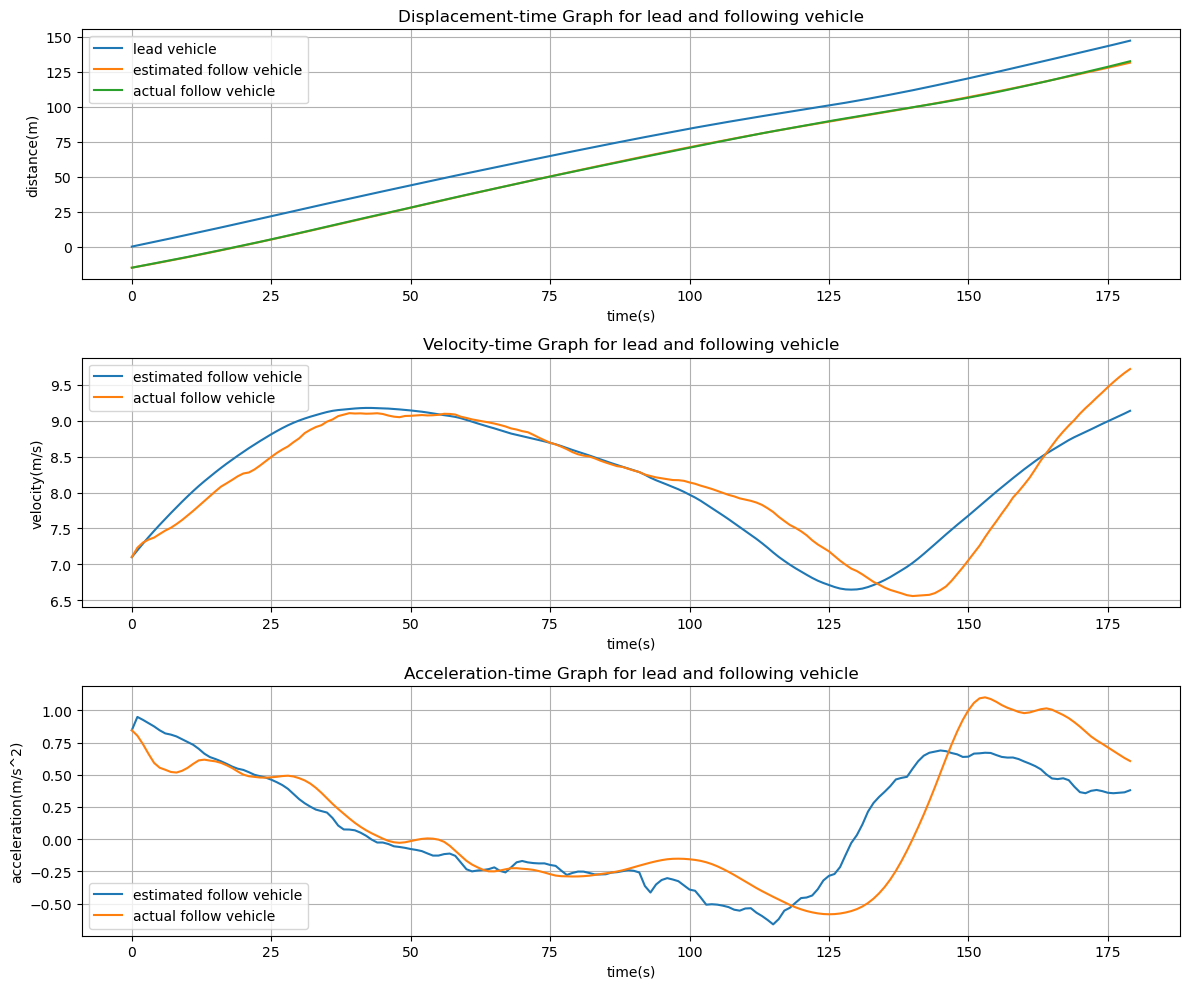

In [42]:
# simulated vehicle trajectories, velocity, acceleration comparison to the real data 
i = 108
param = get_idm_param()
get_car_following_images(i, param)

When the value of error is greater than 2.0, the error is considered to be too large, so these values are filtered out first. The values of v0 and a are both high, v0 is as high as 33.33km/h at 75%, and the average value of a reaches 1.38km/s^2. It can be seen that the driving behavior of drivers on this section of the road is relatively aggressive.

In [7]:
file_path = "../data/parameters.csv"
df = pd.read_csv(file_path)

# filter the rows with error larger than 2, these parameter sets could be not credible.
filtered_df = df[df['error'] < 2]
filtered_df.describe()

,id,Scenes,v0,s0,T,a,b,sigma,error
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.0,402.000000
mean,251.278607,1071.004975,22.977474,2.365821,0.745821,1.377985,2.232687,4.0,1.166672
std,142.616788,665.727513,8.166960,1.480995,0.209143,0.628971,0.373003,0.0,0.399293
min,0.000000,1.000000,9.444444,0.010000,0.500000,0.800000,1.500000,4.0,0.344880
25%,132.250000,528.250000,15.277778,0.940000,0.560000,0.830000,1.950000,4.0,0.860420
50%,244.500000,934.500000,19.861111,2.410000,0.710000,1.070000,2.500000,4.0,1.130611
75%,376.750000,1694.000000,33.333333,4.000000,0.860000,1.902500,2.500000,4.0,1.448640
max,498.000000,2261.000000,33.333333,4.000000,1.610000,2.500000,2.500000,4.0,1.997300


## 4.3 Pros and Cons

### 4.3.1 Pros

- IDM is capable of describing most of regimes in car following, as long as enough data samples (i.e. including ADF regimes) are given.
- IDM provides various parameters to describe the heterogeneity of different drivers, which is good for parameter estimations, and brings up the accuracy of the model

### 4.3.2 Cons

- IDM is still too simplified, and parameter estimation is totally based on general / heuristic optimization algorithms, which could bring some inaccuracies when estimating.
- Even though IDM is based on calculated acceleration to update the steps, it still fails to capture the difference between the theoretical acceleration and the real one.

# 5. Limitations and further research

## 5.1 Limitation
Although a lot of data processing as well as visualization was accomplished, the project had many shortcomings  
The first is that all data spans 15 seconds in 0.1 second steps, and while this provides high-resolution data, this level of granularity can lead to information overload when analyzing macro traffic flows and may not always provide useful macro traffic characteristics.  
The second point is the lack of scene-specific information:
- Driver behavior is unknown: it is not known what the driver's state is, such as fatigue, distraction, or aggressive driving habits, all of which are key factors affecting traffic flow.

The third point is that the data is discrete, which can create two problems:
- Lack of long-term trends: it may be difficult to analyze long-term trends and patterns in traffic flow due to discrete data.
- Complexity management: complex algorithms and models may need to be developed to extract meaningful macro information from this type of data.

## 5.2 Further research

To overcome these challenges, the following steps may be required:

- Data Aggregation: using longer time steps to reduce noise and improve data manageability.
- Feature Engineering: developing sophisticated feature engineering methods to identify and separate outliers, short-term fluctuations, and actual traffic patterns.
- Model Development: using advanced statistical methods and machine learning models to parse and predict traffic mobility.

# References

1. [Guopeng Li, Yiru Jiao, Victor L. Knoop, Simeon C. Calvert, and J.W.C. van Lint. Large Car-following Data Based on Lyft level-5 Open Dataset: Following Autonomous Vehicles vs. Human-driven Vehicles.](https://arxiv.org/pdf/2305.18921.pdf)

2. [A. Sharma, Z. Zheng, and A. Bhaskar, “Is more always better? the impact of vehicular trajectory completeness on car-following model calibration and validation,” Transportation Research Part B: Methodological, vol. 120, pp. 49–75, 2019.](https://www.sciencedirect.com/science/article/pii/S0191261518301528)


3. [The Intelligent-Driver Model and its Variants](https://traffic-simulation.de/info/info_IDM.html)

4. [Wikipedia: Car classification](https://en.wikipedia.org/wiki/Car_classification)
